Mounting Google Drive

Mounting Google Drive and setting the working directory to the folder `My Drive/LDA project`:

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/LDA project/data"
!ls # contains the "chest_xray" folder

/content/drive/MyDrive/LDA project/data
chest_xray


# LDA for Classification: Predicting Star Types
---
In the below cells we will walk through our implementation of Linear Discriminant Analysis on a multiclass classificaion problem. In particular, we will be predicting star types based on attributes of the star such as temperature, luminosity, size, etc.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

## Loading data
We first load our data and observe its arrangement for preprocessing

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/warewaware/LDA156FinalProj/main/source/data/star_data.csv")
data

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class,Star type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


## Data preprocessing

As full disclosure, some editing was done on the source csv to begin with, but these edits were limited to arrangement of columns and grouping certain Star Color fields into one group, namely fixing letter cases and grouping unnecessarily pedantic distinctions of color into one group.

The star types are mapped to the following class labels


    Brown Dwarf -> Star Type = 0
    Red Dwarf -> Star Type = 1
    White Dwarf-> Star Type = 2
    Main Sequence -> Star Type = 3
    Supergiant -> Star Type = 4
    Hypergiant -> Star Type = 5



We immediately notice a few of things:

1. The 'Star color' attribute is non-numeric
2. The 'Spectral Class' attribute is non-numeric

To preprocess the data in order to fix the first two observations, we can simply choose a suitable map of the star color and spectral classes to some integers.

As for point 3, we will change those values with a `0` star type to `-1` in order to avoid possible issues with information loss in the discriminant analysis.

We use the following scheme for the Star Color:

| Star Color         | Mapped Value |
|--------------------|--------------|
| Red                | -5           |
| Orange-Red         | -4           |
| Orange             | -3           |
| Pale yellow orange | -2           |
| Yellow-White       | -1           |
| Whitish            | 0            |
| White              | 1            |
| Blue-White         | 2            |
| Blue               | 3            |

We make this choices centered around `'White'` being `1`, the redder hues being more negative values, with the bluer hues being more positive.

We use the following scheme for the Spectral Class:
 
 | Spectral Class | Mapped Value |
|----------------|--------------|
| O              | 5            |
| B              | 4            |
| A              | 3            |
| F              | 2            |
| G              | 1            |
| K              | 0            |
| M              | -1           |

The rationale for these choices is again a simple heuristic that the Sun is classified as a a G type star, hence those stars in the G class will be similar to the Sun, with the redder, dimmer K and M star types being represented with the more negative numbers and the brighter, bluer star types O, B, A, and F being more positive numbers. It should be noted that these choices will have no significant effect on the model. They are ultimately arbitrary choices.

In [ ]:
spectra_map = {'O':5, 'B':4, 'A':3, 'F':2, 'G':1, 'K':0, 'M':-1}
color_map = { 'Red':-5, 'Orange-Red':-4, 'Orange':-3, 'Pale yellow orange':-2, 
             'Yellow-White':-1, 'Whitish':0, 'White':1,
             'Blue-White': 2, 'Blue':2}

data.replace(spectra_map,inplace=True)
data.replace(color_map, inplace=True)

data

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class,Star type
0,3068,0.002400,0.1700,16.12,-5,-1,0
1,3042,0.000500,0.1542,16.60,-5,-1,0
2,2600,0.000300,0.1020,18.70,-5,-1,0
3,2800,0.000200,0.1600,16.65,-5,-1,0
4,1939,0.000138,0.1030,20.06,-5,-1,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,2,5,5
236,30839,834042.000000,1194.0000,-10.63,2,5,5
237,8829,537493.000000,1423.0000,-10.73,1,3,5
238,9235,404940.000000,1112.0000,-11.23,1,3,5


We note that the spectral type of stars depends on data that is already present in the data (e.g. temperature, absolute magnitude etc.)

We found in our testing that dropping the spectral type attribute yielded a slightly more accurate model, so we will be dropping this attribute from here on.

## Implementing the algorithm

We rely on scikit-learns's built-in model to implement.

To adjust the training data test size, simply adjust the `train_size` parameter to an `int` for actual size of the data (this requires a value between `7` and `240`), or a `float` between `0` and `1.0` to define a percentage of the full dataset.

In [ ]:
# Function to split data into train and test sets
from sklearn.model_selection import train_test_split
# Tools to analyze model accuracy
from sklearn.metrics import accuracy_score

#X, y = data.drop(columns=['Spectral Class', 'Star type']), data['Star type']
X, y = data.drop(columns=['Spectral Class','Star type']), data['Star type']

# Define train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                    random_state=0)

# Initialize model
model = LDA(solver='eigen',shrinkage=None)
# Fit training set
model.fit(X_train, y_train)

# Load predicted classes and analyze performance
predicted = model.predict(X_test)

print("Model accuracy:", accuracy_score(y_test, predicted))

Model accuracy: 0.9861111111111112


## Accuracy analysis
The above implementation makes use of the `random_state` input in the `train_test_split` function which keeps the split consistent between multiple executions of the code. See the [scikitlearn documentation](https://https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more information. 

As seen, this results in an accuracy of 98.6%, but this is for just one such split of the data. For a more robust picture of the LDA model accuracy that is not dependent on the `random_state` parameter for splitting our data, we take the mean of the model's error over several random choices of training data.

Model accuracy over 50 splits
Mean:    0.9886111111111111
Std dev: 0.011348165675453048


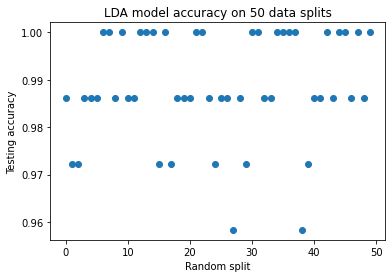

In [ ]:
def LDA_error(X, y, train_size, random_state):
  # Define train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      train_size=train_size, 
                                                      random_state=random_state)
  model = LDA(solver='eigen',shrinkage=None).fit(X_train, y_train)
  return accuracy_score(y_test, model.predict(X_test))

n_iter = 50
errors = [LDA_error(X, y, train_size=0.7, random_state=i) 
          for i in range(n_iter)]

print(f"Model accuracy over {n_iter} splits")
print("Mean:   ", np.mean(errors))
print("Std dev:", np.std(errors))

plt.scatter(range(n_iter), errors)
plt.title(f"LDA model accuracy on {n_iter} data splits")
plt.xlabel("Random split")
plt.ylabel("Testing accuracy")
plt.show()

As a slight aside, we use LDA's strength as a data visualization tool by projecting our data to 2D and plotting.

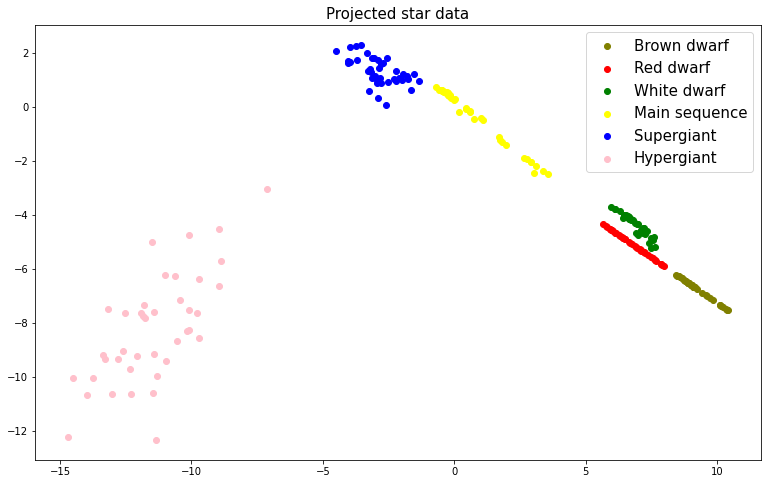

In [ ]:
redux = LDA(n_components=2,solver='eigen',shrinkage=None)
attr = data.loc[:,'Temperature (K)':'Star color']
lab = data.loc[:,'Star type']
redux.fit( attr, lab)
red  = redux.transform(attr)
colors = [("Brown dwarf", 'olive'), ("Red dwarf",'red'),("White dwarf",'green'),
          ("Main sequence",'yellow'), ("Supergiant",'blue'), 
          ("Hypergiant",'pink')]
red_list = [ red[lab==i] for i in [0,1,2,3,4,5]]
plt.figure(figsize=(13,8))
for i in range(6):
  plt.scatter(red_list[i][:,0],red_list[i][:,1],
              label=colors[i][0],color=colors[i][1])
plt.legend(fontsize=15)
plt.title("Projected star data",fontsize=15)

plt.show()

The result is reminiscent of a Hertzprung-Russell Diagram (modulo some affine transformation).

# LDA as a Supervised Dimension Reduction Technique

Having demonstrated the utility of LDA as a multiclass classifier model, we turn to another one of LDA's applications: dimension reduction.

Having already learned about Principal Component Analysis (PCA), we feel the only further motivation of the utility of LDA as a dimension reduction routine is to compare it PCA.

The primary difference between LDA and PCA as dimension reduction routines is that LDA is supervised, where the presence of the data's class labels is used to reduce the dimensionality of the data by using only the most discriminative attributes. It does this finding a projection subspace that maximizes the between-class scatter and minimizes the within-class scatter. Intuitively this can be though of as finding a subspace that maximizes the 'spread' between two different class label groups of data points while keeping the elements of one class as 'tight' as possible.

The use cases of LDA and PCA are also different. LDA is primarily used to reduce dimension in the case that class separability are desirable. On the other hand, PCA's ability to preserve the variance in data means it should be used when data variance preservation is desired.

## LDA vs. PCA

Rather than explain the differences between LDA and PCA on a theoretical level, we practically demonstrate their differences by reducing the dimension of the classic wine quality dataset built into scikitlearn.

The wine quality dataset is a collection of 178 samples of distinct wines, noting 13 different attributes about each wine, that culminate in quality score. The quality scores are grouped into three classes, labelled `0`, `1`, and `2`.

In the below cell we run a very simple script of reducing these 13 dimensions to 2, and plotting the results to compare.

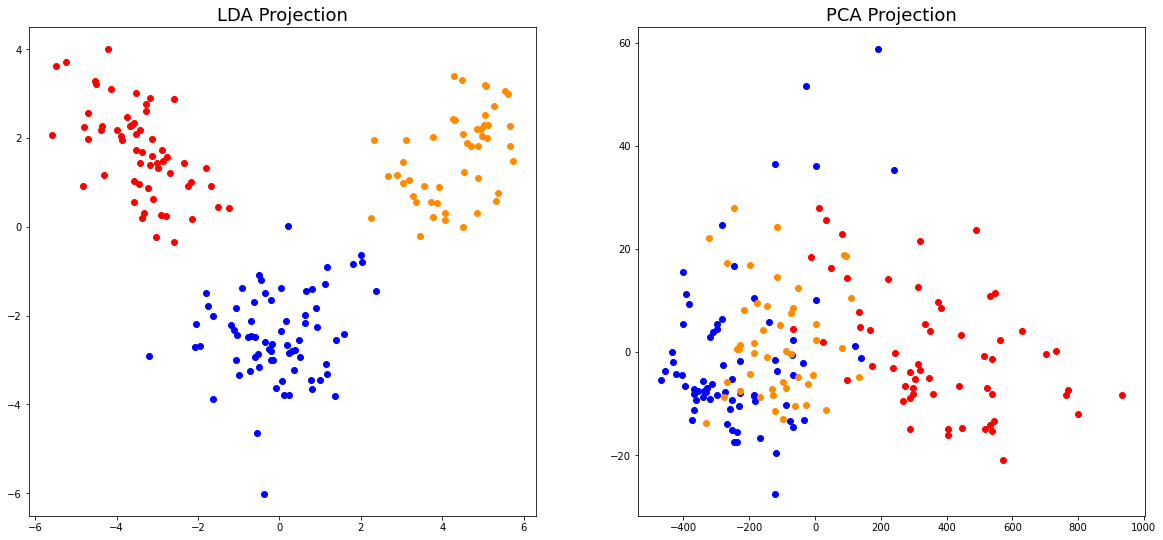

In [ ]:
from sklearn.datasets import load_wine
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis \
    as LDA
from sklearn.decomposition import PCA

# Load and separate data
wine = load_wine()
X, y = wine.data, wine.target

models = [LDA(n_components=2), PCA(n_components=2)]
proj = [m.fit_transform(X, y) for m in models]

# Plot the projected data
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
model_names = ['LDA', 'PCA']
colors = ['red', 'blue', 'darkorange']
for i in range(2):
    for label in range(3):
        ax[i].scatter(proj[i][y==label][:,0], proj[i][y==label][:,1], 
                      color=colors[label])
    ax[i].set_title(model_names[i] + " Projection", fontsize=18)
fig.show()

As one can see, the supervision of the LDA projection subspace gives it a clear advantage if the goal is to maintain separability between classes.

The plots may lead one to believe that PCA is a rather poor method to reduce dimensionality, but it should be remembered that PCA's primary goal is not to preserve class separability (it is unsupervised after all). Instead, PCA is superior in the preservation of **variance**.

In sum, if one is to think of dimension reduction as a means to reduce dimension while preserving 'fidelity' of the data, the usefulness of PCA and LDA will be determined by how one defines data 'fidelity'. If data's distinction as being of a particular class is the desired fidelity, then LDA is appropriate, but if the data's uniqueness from the other data (i.e. variance) is a priority, then PCA is appropriate.

## Chest X-rays

We now demonstrate a high-dimensional binary classification where LDA is again used as a dimension reduction technique. Our dataset of chest X-ray images is divided into three classes (normal, bacterial pneumonia, and viral pneumonia), but we only seek to distinguish between normal X-rays and pneumonia X-rays, regardless of the type of pneumonia. Thus, in order to retain as much information during the dimension reduction, we first consider all three classes when fitting the LDA model. This allows us to project our feature vectors onto an eigenspace of dimension 2 rather than dimension 1. We then train various binary classification models using the reduced data.

We begin with the dimension reduction first:

In [ ]:
import glob
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from PIL import Image
import time

In [ ]:
"""
@author: Abhijith Vemulapati
@created: Sat Nov 21 20:30:00 2020
@description: Implementation of LDA dimension reduction and various binary classifiers on X-ray data
"""

dim = 200
n_samples = 750

# Change this to the local path of chest_xray directory
# datapath = "/content/drive/MyDrive/LDA project/data/chest_xray/"
datapath = "./chest_xray/"
train_path = datapath + 'train/'
test_path = datapath + 'test/'

np.random.seed(int(time.time()))

In [ ]:
def applySobel(im):
    im = im.astype('int32')
    dx = ndimage.sobel(im, 1)  # horizontal derivative
    dy = ndimage.sobel(im, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)
    return mag

# Open all images in a directory and generate feature matrix X with shape (n_samples, dim**2)
def getFeatureMatrix(dirname, filenames, path, sample=True):
    filenames_sample = np.array(filenames)[np.random.choice(len(filenames), 
                                                            n_samples, 
                                                            replace='False')]
    images = list(map(lambda f: Image.open(f).resize((dim,dim)), 
                      filenames_sample))
    imageArr = map(lambda i: applySobel(np.array(i)), images)
    # Convert any RGB images to grayscale
    imageArr = [0.2126*i[:,:,0] + 0.7152*i[:,:,1] + 0.0722*i[:,:,2] if len(i.shape) == 3 else i for i in imageArr]
    return np.array(imageArr).reshape(len(imageArr), dim**2)

In [ ]:
normal_files = glob.glob(train_path + 'NORMAL/*')
pneumonia_files = glob.glob(train_path + 'PNEUMONIA/*')

# Split pneumonia images into bacterial and viral
bacterial_p_files = list(filter(lambda f: 'bacteria' in f, pneumonia_files))
virus_p_files = list(filter(lambda f: 'virus' in f, pneumonia_files))

In [ ]:
# Generate feature matrix and class tags for each class
normal_features = getFeatureMatrix('NORMAL', normal_files, train_path)
normal_tags = np.zeros((normal_features.shape[0],))

bac_features = getFeatureMatrix('PNEUMONIA', bacterial_p_files, train_path)
bac_tags = np.ones((bac_features.shape[0],))

virus_features = getFeatureMatrix('PNEUMONIA', virus_p_files, train_path)
virus_tags = np.ones((virus_features.shape[0],)) + 1

In [ ]:
# virus_tags should be treated as a separate class in the first step of the model
X = np.concatenate((normal_features, bac_features, virus_features))
y = np.concatenate((normal_tags, bac_tags, virus_tags))

print(X.shape)
print(y.shape)

np.save("xray_attributes.npy", X)
np.save("xray_labels.npy", y)

(2250, 40000)
(2250,)


In [ ]:
# Run LDA to project data on two dimensional subspace
LDA_model = LDA(n_components=2)
LDA_model.fit(X, y)

LinearDiscriminantAnalysis(n_components=2)

Now that we have fit the model to the training data, we have generated a 2-D eigenspace using the intraclass and interclass covariance matrices. We now project the image data onto this eigenspace to fit the reduced data to three different binary classifier models and classify between normal images and pneumonia images.

In [ ]:
# Transform training data to run logistic regression on dimension-reducted data
transformed_normal = LDA_model.transform(normal_features)
transformed_pneumonia = LDA_model.transform(np.concatenate((bac_features, 
                                                            virus_features)))
# Sample 750 images from pneumonia set to keep have number of samples from each class in logistic regression training
transformed_pneumonia = transformed_pneumonia[np.random.choice(transformed_pneumonia.shape[0], 
                                                               n_samples, replace=False)]
transformed_X = np.concatenate((transformed_normal, transformed_pneumonia))

# Tag transformed data without distinction within pneumonia data
y_bin = np.concatenate((normal_tags, np.ones((transformed_pneumonia.shape[0]))))

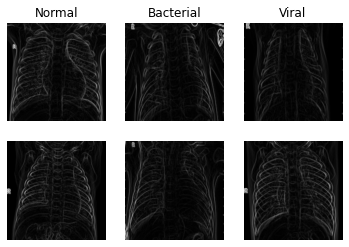

In [ ]:
# Plot sample of chest X-rays after application of Sobel operator
fig, axes = plt.subplots(2,3)
imgs = [normal_features[0,:],normal_features[1,:],bac_features[0,:],
        bac_features[1,:],virus_features[0,:],virus_features[1,:]]
plt.axis('off')
for j in np.arange(3):
    for i in np.arange(2):
        axes[i,j].axis('off')
        if i == 0: axes[i,j].title.set_text(['Normal','Bacterial','Viral'][j])
        axes[i,j].imshow(np.reshape(imgs[2*j+i], (dim,dim), order = 'C'), 
                         cmap = 'gray')

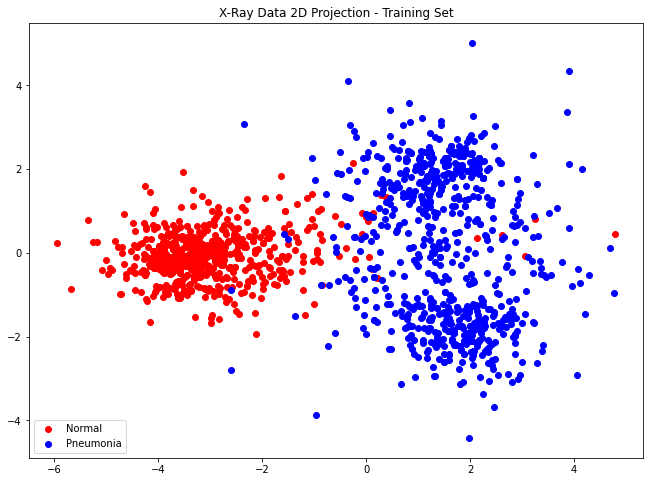

In [ ]:
plt.figure(figsize=(11,8))
transformed = [transformed_normal, transformed_pneumonia]
cols = [('Normal','red'),('Pneumonia','blue')]
for cls, col in zip(transformed, cols):
    plt.scatter(cls[:,0],cls[:,1],color=col[1], label=col[0])
plt.title('X-Ray Data 2D Projection - Training Set')
plt.legend(loc = 'lower left')

In [ ]:
logistic_regress_model = LogisticRegression()
logistic_regress_model.fit(transformed_X, y_bin)

svm_model = SVC()
svm_model.fit(transformed_X, y_bin)

lda_binary_model = LDA()
lda_binary_model.fit(transformed_X, y_bin)

LinearDiscriminantAnalysis()

Having fitted the binary regression models, we now run the test set through our two-step model: We generate the feature matrix and the corresponding target vector for the test set, apply our 2D LDA projection to reduce dimension, and then run all three binary classifiers on our test set. 

In [ ]:
normal_test_files = glob.glob(test_path + 'NORMAL/*')
pneumonia_test_files = glob.glob(test_path + 'PNEUMONIA/*')

normal_test_features = getFeatureMatrix('NORMAL', normal_test_files, test_path)
pneumonia_test_features = getFeatureMatrix('PNEUMONIA', pneumonia_test_files, 
                                           test_path)

transformed_normal_test = LDA_model.transform(normal_test_features)
transformed_pneumonia_test = LDA_model.transform(pneumonia_test_features)
transformed_X_test = np.concatenate((transformed_normal_test, 
                                     transformed_pneumonia_test))

normal_tags_test = np.zeros((normal_test_features.shape[0],)) 
pneumonia_tags_test = np.ones((pneumonia_test_features.shape[0],))
tags_test = np.concatenate((normal_tags_test, pneumonia_tags_test))

In [ ]:
lr_accuracy = logistic_regress_model.score(transformed_X_test, tags_test)

svm_accuracy = svm_model.score(transformed_X_test, tags_test)

lda_accuracy = lda_binary_model.score(transformed_X_test, tags_test)

print('Logistic Regression Accuracy: ' + str(lr_accuracy))
print('SVM Regression Accuracy: ' + str(svm_accuracy))
print('LDA Regression Accuracy: ' + str(lda_accuracy))

Logistic Regression Accuracy: 0.7406666666666667
SVM Regression Accuracy: 0.7493333333333333
LDA Regression Accuracy: 0.732


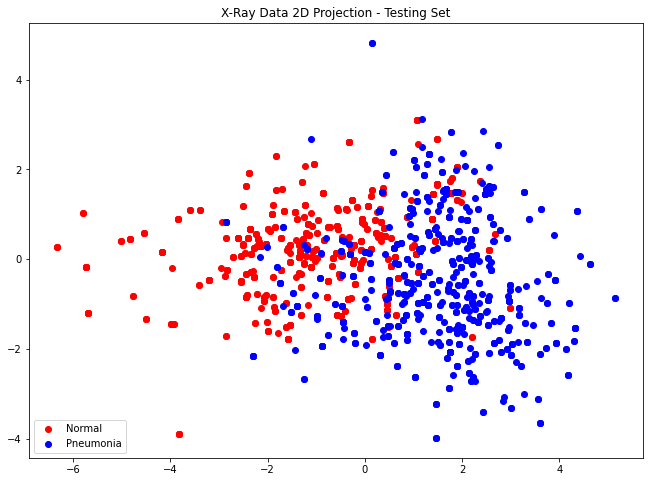

In [ ]:
plt.figure(figsize=(11,8))
transformed_test = [transformed_normal_test, transformed_pneumonia_test]
cols = ['red', 'blue']
cols = [('Normal','red'),('Pneumonia','blue')]
for cls, col in zip(transformed_test, cols):
    plt.scatter(cls[:,0],cls[:,1],color=col[1], label=col[0])
plt.title('X-Ray Data 2D Projection - Testing Set')
plt.legend(loc = 'lower left')

We find that our accuracy sits around 95% for the training set and 73% for the test set. The eigenspace generated from the training data seems to overfit the training set but still yields a modest accuracy rate on the testing data.

## Fashion MNIST

MNIST image data is regularized much better than the previous X-ray dataset, so it is likely to perform better with dimension reduction.

Our dataset consists of 60,000 samples of 28x28 images flattened to `(784,1)` size array. Each image is of a single piece of clothing, which is one of 10 different articles of clothing with the following class labels:

| Type of Clothing | Class Label |
|------------------|-------------|
| T-shirt/Top      | 0           |
| Trousers         | 1           |
| Pullover         | 2           |
| Dress            | 3           |
| Coat             | 4           |
| Sandals          | 5           |
| Shirt            | 6           |
| Sneakers         | 7           |
| Bag              | 8           |
| Ankle Boot       | 9           |

We will reduce the dimension this data to a number of smaller dimensions between 2 and 9 and run various classifiers to compare model accuracy at varying levels of dimension reduction.
The explanations of the various classifiers are out of the scope of this project, we will simply be using them with their default settings provided by scikitlearn.
We will also visualize the data projected to 3 dimensions.

In [ ]:
# Several classifiers will be used naively
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# To scale the data for SVM
from sklearn import preprocessing

import random

In [ ]:
# Load data
data_train = pd.read_csv(
    "/content/drive/MyDrive/LDA Final Project/fashion-mnist_train.csv")
data_test = pd.read_csv(
    "/content/drive/MyDrive/LDA Final Project/fashion-mnist_test.csv")

# Split data into train and test attributes and labels
# Also scale the data
train_labels = data_train.iloc[:,0]
train_attr = data_train.iloc[:,1:]
scaler = preprocessing.StandardScaler().fit(train_attr)
train_attr = scaler.transform(train_attr)

test_labels = data_test.iloc[:,0]
test_attr = data_test.iloc[:,1:]
test_attr = scaler.transform(test_attr)

With the data loaded, we reduce and classify using our various classifiers.

In [ ]:

classifiers = [ ('Decision Tree', DecisionTreeClassifier()), # Decision tree
                 ('Random Forest', RandomForestClassifier()), # Random forest
               ('Support Vector RBF', SVC(kernel='rbf')), # SVM rbf kernel
              ('Support Vector poly', SVC(kernel='poly')), # SVM polynomial kernel
               ('Gaussian Naive Bayes', GaussianNB()) # Gaussian Naive Bayes
]

NUM_CLASSES = max(train_labels)
scores =np.zeros(shape=(5,6))

# Run each classifier for each dimension we reduce to
for RED_DIM in range(3,NUM_CLASSES):
  model = LDA(n_components=RED_DIM,solver='eigen',shrinkage='auto')
  model.fit(train_attr,train_labels)
  proj_train = model.transform(train_attr)
  proj_test = model.transform(test_attr)
  i = 0
  for m in classifiers:
    m[1].fit(proj_train,train_labels)
    score = m[1].score(proj_test,test_labels)
    scores[i,RED_DIM-3] = score
    i += 1
    print(f'{m[0]} score on {RED_DIM}-dimensional reduced data:', score)
  print('\n')
print(scores)

Decision Tree score on 3-dimensional reduced data: 0.6038
Random Forest score on 3-dimensional reduced data: 0.6646
Support Vector RBF score on 3-dimensional reduced data: 0.6836
Support Vector poly score on 3-dimensional reduced data: 0.6701
Gaussian Naive Bayes score on 3-dimensional reduced data: 0.6665


Decision Tree score on 4-dimensional reduced data: 0.6319
Random Forest score on 4-dimensional reduced data: 0.6953
Support Vector RBF score on 4-dimensional reduced data: 0.706
Support Vector poly score on 4-dimensional reduced data: 0.6932
Gaussian Naive Bayes score on 4-dimensional reduced data: 0.6938


Decision Tree score on 5-dimensional reduced data: 0.6864
Random Forest score on 5-dimensional reduced data: 0.7563
Support Vector RBF score on 5-dimensional reduced data: 0.7549
Support Vector poly score on 5-dimensional reduced data: 0.7373
Gaussian Naive Bayes score on 5-dimensional reduced data: 0.7299


Decision Tree score on 6-dimensional reduced data: 0.7253
Random Forest

We can visualize how the error changes for each model on the next figure.

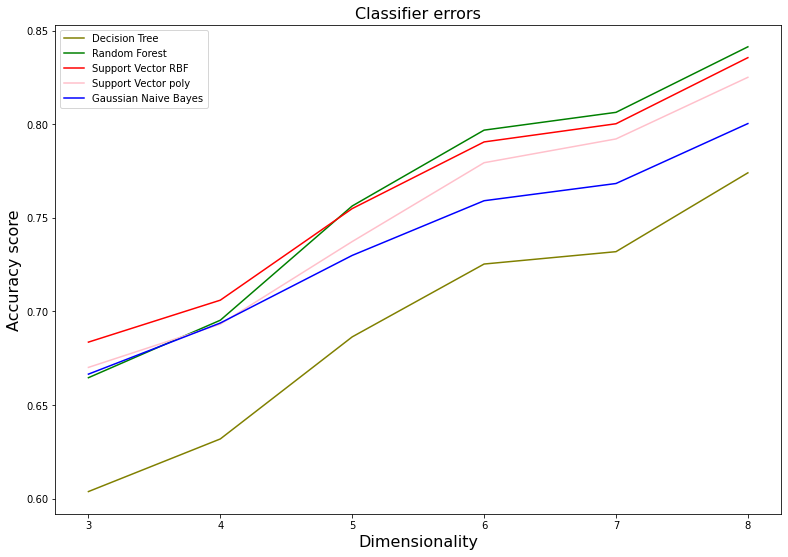

In [ ]:
score_dict = { classifiers[i][0]:scores[i] for i in range(len(scores)) }

dims = np.arange(3,9)

plt.figure(figsize=(13,9))
colors = [ 'olive', 'green', 'red', 'pink', 'blue']

for errs ,j in zip(score_dict.items(),colors):
  plt.plot(dims, errs[1],color=j,label=errs[0])

plt.title("Classifier errors",fontsize=16)
plt.xlabel("Dimensionality",fontsize=16)
plt.ylabel("Accuracy score",fontsize=16)
plt.legend()
plt.show()

We see that all models make relatively small gains between dimensions 6 and 7, future exploration of LDA might be to determine why increasing dimensionality to certain levels increase accuracy more than others, e.g. going from dimensions 7 to 8 increased accuracy for all models far more than going from 6 to 7.

We now visualize the LDA projection of the data to 3D by plotting some number of points.


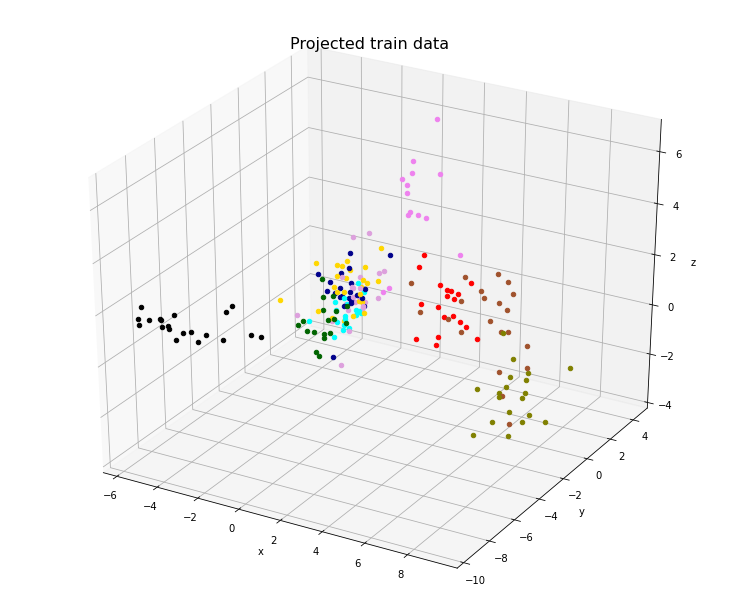

In [ ]:
from mpl_toolkits import mplot3d

RED_DIM = 3

model = LDA(n_components=RED_DIM,solver='eigen',shrinkage='auto')
model.fit(train_attr,train_labels)

red_data_train = model.transform(train_attr)
colors = ['aqua', 'black', 'darkblue', 'darkgreen', 'gold', 'red', 'plum',
          'sienna', 'violet', 'olive']

# # Number of points to plot
NUM_POINTS = 200

if RED_DIM == 3:
    fig = plt.figure(figsize=(13,11))
    ax = plt.axes(projection="3d")
    for i in random.sample(range(len(red_data_train)),NUM_POINTS):
        X = red_data_train[i,0]
        Y = red_data_train[i,1]
        Z = red_data_train[i,2]
        ax.scatter3D(X,Y,Z, color=colors[train_labels[i]])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title("Projected train data",fontsize=16)
    plt.show()

We can see LDA does a fairly good job of retaining class separability, moreso than the X-ray data.
We conclude this is due to the lower variance of the data, as the MNIST dataset has been regularized in image size, cropping, framing, etc.